1.   Нужно написать приложение, которое будет получать на вход изображение.
2.   В процессе определять, что перед камерой находится человек, задетектировав его лицо на кадре.
3.   На изображении определить эмоцию.

In [7]:
#Загрузка библиотек
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable

In [29]:
#Загрузчик с диска гугл
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Загрузим датасет

In [8]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1sJPwIzxDpwFds1LhLcB3woVb7lS4zhm1' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1sJPwIzxDpwFds1LhLcB3woVb7lS4zhm1" -O emotion_recognition.zip && rm -rf /tmp/cookies.txt 

--2022-06-22 11:20:20--  https://docs.google.com/uc?export=download&confirm=t&id=1sJPwIzxDpwFds1LhLcB3woVb7lS4zhm1
Resolving docs.google.com (docs.google.com)... 173.194.212.102, 173.194.212.139, 173.194.212.113, ...
Connecting to docs.google.com (docs.google.com)|173.194.212.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1ijnrfvictrofrdlfn4gnbfh69961j0d/1655896800000/14904333240138417226/*/1sJPwIzxDpwFds1LhLcB3woVb7lS4zhm1?e=download [following]
--2022-06-22 11:20:20--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1ijnrfvictrofrdlfn4gnbfh69961j0d/1655896800000/14904333240138417226/*/1sJPwIzxDpwFds1LhLcB3woVb7lS4zhm1?e=download
Resolving doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 172.217.204.132, 2607:f8b0:400c:c15::84
Connecting to doc-0s-c0-docs.googleusercontent.com (doc-

In [9]:
!unzip emotion_recognition.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.

In [10]:
classes_train = os.listdir("./train")
classes_test = os.listdir("./test")

In [11]:
#Данные трен
for emotion in os.listdir('./train'):
    print(emotion, len(os.listdir(f'./train/{emotion}')))

angry 3995
happy 7215
neutral 4965
disgust 436
sad 4830
fear 4097
surprise 3171


In [12]:
#Данные тест
for emotion in os.listdir('./test'):
    print(emotion, len(os.listdir(f'./test/{emotion}')))

angry 958
happy 1774
neutral 1233
disgust 111
sad 1247
fear 1024
surprise 831


In [13]:
def digit_to_classname(digit):
    if digit == 0:
        return 'angry'
    elif digit == 1:
        return 'disgust'
    elif digit == 2:
        return 'fear'
    elif digit == 3:
        return 'happy'
    elif digit == 4:
        return 'neutral'
    elif digit == 5:
        return 'sad'
    elif digit == 6:
        return 'surprise'

In [14]:
#трансформация датасета
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), # Картинки черно-белые
                         # Настройки для расширения датасета
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         tt.ToTensor()])                      # Приведение к тензору

test_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

In [15]:
train_ds = ImageFolder('./train', train_tfms)
test_ds = ImageFolder('./test', test_tfms)

In [16]:
batch_size = 256

In [17]:
#Создадим даталоадеры
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size, num_workers=1, shuffle=False)

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [14]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [15]:
model = ResNet(1, len(classes_train)).to(device)

In [26]:
epochs = 15
max_lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), max_lr)

In [27]:
epoch_losses = []

for epoch in range(epochs):
    
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dl):
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        
    test_running_loss = 0
    test_epoch_loss = []
    for batch_idx, (data, labels) in enumerate(test_dl):
        model.eval()
        data = data.to(device)
        labels = labels.to(device)
        
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
                
        test_running_loss += loss.item()
        test_epoch_loss.append(loss.item())
        
        
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss), 'test loss:', np.mean(test_epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 1, loss:  2.822147327186787 test loss: 1.922320813968264
Epoch 2, loss:  1.827171078825419 test loss: 1.997726204066441
Epoch 3, loss:  1.814243546629374 test loss: 1.8664743078166042
Epoch 4, loss:  1.7853513755629549 test loss: 1.7792680921225712
Epoch 5, loss:  1.7727425646992911 test loss: 1.7714454305583034
Epoch 6, loss:  1.7574462890625 test loss: 1.7279107899501407
Epoch 7, loss:  1.7305510434429203 test loss: 1.734963429385218
Epoch 8, loss:  1.678381974718212 test loss: 1.648151109958517
Epoch 9, loss:  1.622353448277026 test loss: 1.5809749159319648
Epoch 10, loss:  1.5495308542673567 test loss: 1.4276303258435479
Epoch 11, loss:  1.451348041011169 test loss: 1.503509486543721
Epoch 12, loss:  1.3940622806549072 test loss: 1.2772996137882102
Epoch 13, loss:  1.3031429210595324 test loss: 1.283669131583181
Epoch 14, loss:  1.2641705949749567 test loss: 1.2236913545378323
Epoch 15, loss:  1.2033650790695596 test loss: 1.2359312515834282


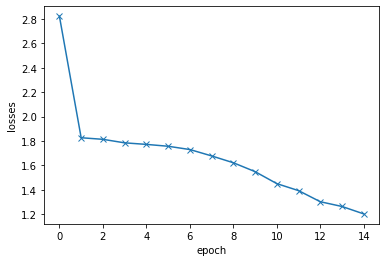

In [28]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses');

In [29]:
torch.save(model, './emotion_detection_model_state.pth')

In [30]:
net = torch.load('./emotion_detection_model_state.pth')
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

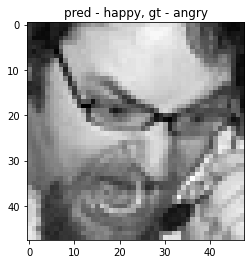

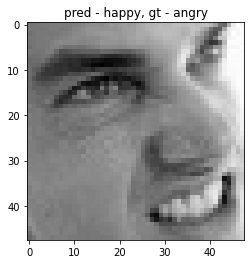

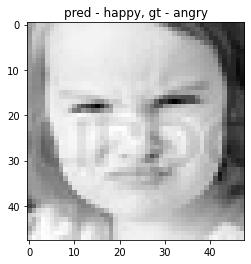

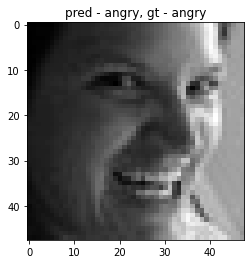

In [31]:
with torch.no_grad():
    for i, data in enumerate(test_dl, 3):
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = net(images)
        plt.title(f'pred - {digit_to_classname(outputs[0].argmax())}, gt - {digit_to_classname(labels[0])}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>5:
            break

In [22]:
!pip install facenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.0 MB/s 


In [32]:
import cv2
import torch
import numpy as np
from facenet_pytorch import MTCNN

    
class FaceDetector(object):
    """
    Face detector class
    """

    def __init__(self, mtcnn):
        self.mtcnn = mtcnn
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.emodel = torch.load('./emotion_detection_model_state.pth')
        self.emodel.eval()

    def _draw(self, frame, boxes, probs, landmarks, emotions):
        """
        Draw landmarks and boxes for each face detected
        """
        try:
            for box, prob, ld, emotion in zip(boxes, probs, landmarks, emotions):
                # Draw rectangle on frame
                cv2.rectangle(frame,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              (0, 0, 255),
                              thickness=2)

                # Show probability
                cv2.putText(frame, 
                    emotion, (box[2], box[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                # Draw landmarks
                cv2.circle(frame, tuple(ld[0]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[1]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[2]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[3]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[4]), 5, (0, 0, 255), -1)
        except:
            pass

        return frame
    
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            # plt.imshow(frame[int(box[1]):int(box[3]), int(box[0]):int(box[2])])
            # plt.show()
            faces.append(frame[int(box[1]):int(box[3]), 
                int(box[0]):int(box[2])])
        return faces
    
    @staticmethod
    def digit_to_classname(digit):
        if digit == 0:
            return 'sad'
        elif digit == 1:
            return 'disgust'
        elif digit == 2:
            return 'happy'
        elif digit == 3:
            return 'surprise'
        elif digit == 4:
            return 'neutral'
        elif digit == 5:
            return 'fear'
        elif digit == 6:
            return 'angry'
       

    def run(self, path_to_img):
        """
            Run the FaceDetector and draw landmarks and boxes around detected faces
        """                
        frame = cv2.imread(path_to_img)
        
        
        # detect face box, probability and landmarks
        boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
        print(boxes)

        faces = self.crop_faces(frame, boxes)
        emotions = []
        for face in faces:
            face = cv2.resize(face,(48,48))
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            
            torch_face = torch.from_numpy(face).unsqueeze(0).to(self.device).float()
            emotion = self.emodel(torch_face[None, ...])
            emotion = self.digit_to_classname(emotion.argmax())
            emotions.append(emotion)

        # draw on frame
        self._draw(frame, boxes, probs, landmarks, emotions)
    
        # Show the frame
        cv2.imwrite('Face_Detection.png', frame)
        plt.figure(figsize=(20, 10))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.show()
        
        
# Run the app
mtcnn = MTCNN()
fcd = FaceDetector(mtcnn)

In [24]:
!wget 'https://phonoteka.org/uploads/posts/2021-05/1620322801_51-phonoteka_org-p-emotsionalnii-fon-vidi-54.jpg' -O test.png

--2022-06-22 09:52:01--  https://phonoteka.org/uploads/posts/2021-05/1620322801_51-phonoteka_org-p-emotsionalnii-fon-vidi-54.jpg
Resolving phonoteka.org (phonoteka.org)... 178.33.214.152
Connecting to phonoteka.org (phonoteka.org)|178.33.214.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245053 (239K) [image/jpeg]
Saving to: ‘test.png’

test.png            100%[===================>] 239.31K   594KB/s    in 0.4s    

2022-06-22 09:52:02 (594 KB/s) - ‘test.png’ saved [245053/245053]



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


[[ 918.07513   530.09265  1081.8768    757.7806  ]
 [1843.3049     85.23267  2013.6783    300.6677  ]
 [1798.6978    526.5316   1949.8287    750.5687  ]
 [ 488.57608   101.32649   637.6932    301.98798 ]
 [ 925.06476   106.45472  1079.4302    297.92706 ]
 [  35.6394    102.41324   184.06708   300.06073 ]
 [ 466.0393    554.1274    616.29865   746.5414  ]
 [  38.23874   548.7638    187.43846   740.87103 ]
 [1361.8834    548.46967  1508.1572    739.9438  ]
 [1372.5715    103.342926 1514.7317    288.66855 ]]


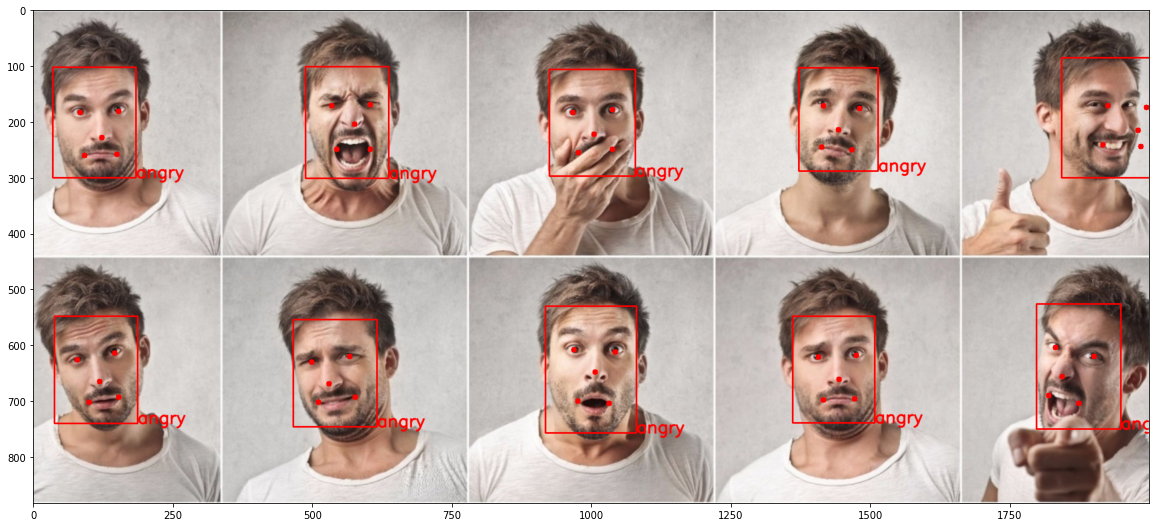

In [33]:
import matplotlib.pyplot as plt

fcd.run('test.png')

Используем готовые библиотеки

In [2]:
pip install FER


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 812 kB 5.1 MB/s 
     |████████████████████████████████| 2.3 MB 34.8 MB/s 


In [4]:
from fer import FER

emo_detector = FER(mtcnn=True)

In [30]:
test_image_one = plt.imread("../content/drive/MyDrive/Colab Notebooks/Torch/10/smail1.jpg")

In [31]:
captured_emotions = emo_detector.detect_emotions(test_image_one)

[{'box': [128, 0, 488, 674], 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.0, 'happy': 1.0, 'sad': 0.0, 'surprise': 0.0, 'neutral': 0.0}}]


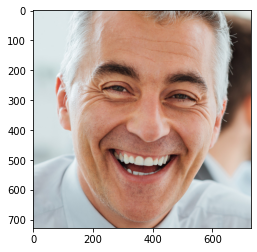

In [32]:
print(captured_emotions)
plt.imshow(test_image_one)

In [33]:
dominant_emotion, emotion_score = emo_detector.top_emotion(test_image_one)
print(dominant_emotion, emotion_score)

happy 1.0


In [41]:
img1 = plt.imread("../content/drive/MyDrive/Colab Notebooks/Torch/10/111.jpg")
img2 = plt.imread("../content/drive/MyDrive/Colab Notebooks/Torch/10/222.jpg")
img3 = plt.imread("../content/drive/MyDrive/Colab Notebooks/Torch/10/333.jpg")
img4 = plt.imread("../content/drive/MyDrive/Colab Notebooks/Torch/10/444.jpg")
img5 = plt.imread("../content/drive/MyDrive/Colab Notebooks/Torch/10/555.jpg")
img6 = plt.imread("../content/drive/MyDrive/Colab Notebooks/Torch/10/666.jpg")
img7 = plt.imread("../content/drive/MyDrive/Colab Notebooks/Torch/10/777.jpg")
img8 = plt.imread("../content/drive/MyDrive/Colab Notebooks/Torch/10/888.jpg")
img9 = plt.imread("../content/drive/MyDrive/Colab Notebooks/Torch/10/999.jpg")


In [42]:
cpis = [img1, img2, img3]

In [49]:
def foto(img):
  captured_emotions = emo_detector.detect_emotions(img)
  dominant_emotion, emotion_score = emo_detector.top_emotion(img)
  return dominant_emotion, emotion_score, captured_emotions

('angry', 0.99)


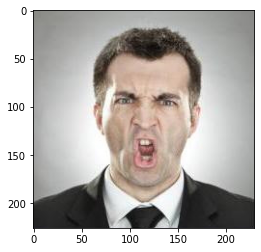

In [52]:
print(foto(img1))
plt.imshow(img1)

('happy', 0.89)


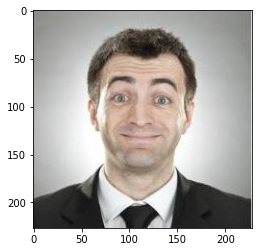

In [53]:
print(foto(img2))
plt.imshow(img2)

('neutral', 0.64)


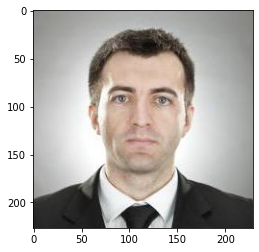

In [54]:
print(foto(img3))
plt.imshow(img3)

('fear', 0.44)


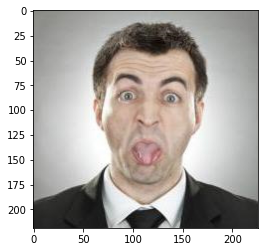

In [55]:
print(foto(img4))
plt.imshow(img4)

('angry', 0.36)


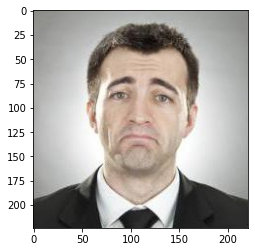

In [56]:
print(foto(img5))
plt.imshow(img5)

('angry', 0.73)


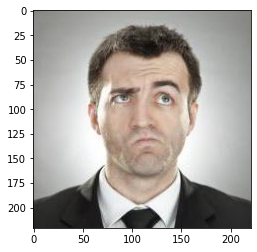

In [59]:
print(foto(img6))
plt.imshow(img6)

('sad', 0.65)


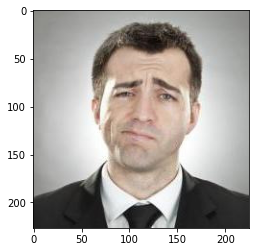

In [58]:
print(foto(img7))
plt.imshow(img7)

('angry', 0.69)


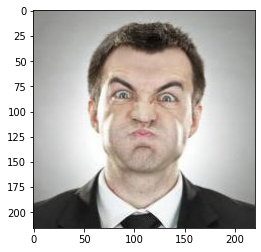

In [60]:
print(foto(img8))
plt.imshow(img8)

('happy', 0.54)


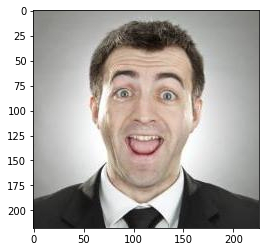

In [61]:
print(foto(img9))
plt.imshow(img9)